# Example

In this exercise, we suggest a model based on XGBOOST to forecast the water inflow 12 hours ahead.

In [2]:
import seaborn as sns
from darts.models import XGBModel

from utils import (
    compare_model_with_baseline,
    example_split_past_future_covariates,
    example_target_and_features,
    example_train_subseries,
    example_test_series,
    visualize_example_measurements,
)

Support for PyTorch based likelihood models not available. To enable them, install "darts", "u8darts[torch]" or "u8darts[all]" (with pip); or "u8darts-torch" or "u8darts-all" (with conda).
Support for Torch based models not available. To enable them, install "darts", "u8darts[torch]" or "u8darts[all]" (with pip); or "u8darts-torch" or "u8darts-all" (with conda).


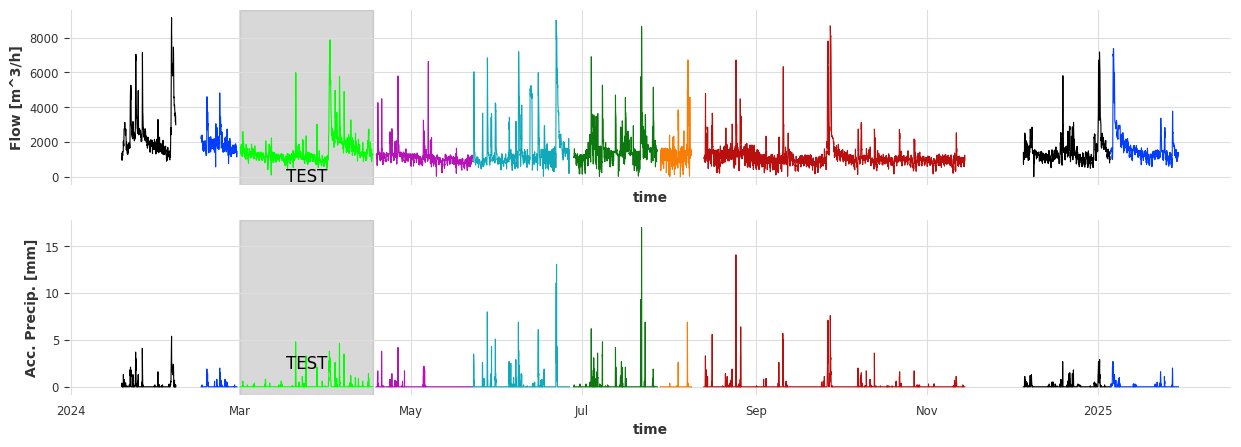

In [3]:
visualize_example_measurements()

## Modelling

In [ ]:
target_var = "flow"

train_subseries = example_train_subseries()
train_target, train_features = example_target_and_features(train_subseries, target_var)
selected_past_covariates, selected_future_covariates = (
    example_split_past_future_covariates(train_features)
)

print(f"Total number of train samples {sum([len(s) for s in train_subseries])}")

Total number of train samples 6961


We defined a model that, to predict the inflow, any given time uses:
- Past observations of pressure, radiation, relative humidity and ambient temperature
- A polynomial function of past and future values of aggregated precipitation (*)
- The day of the week

(* In this exercise, we assume that we have a perfect precipitation rain forecast for the next 12 hours.)

In [11]:
# Modelling parameters
output_chunk_length = 12
n_ar_lags = 6
n_past_lags = 6
n_future_lags = (6, output_chunk_length)
n_lags = max(n_ar_lags, n_past_lags, n_future_lags[1])

# Time encoded features
encoders = {
    "cyclic": {"future": "month"},
    "datetime_attribute": {"future": "hour"},
}

xgbmodel = XGBModel(
    lags=n_ar_lags,
    lags_past_covariates=n_past_lags,
    lags_future_covariates=n_future_lags,
    output_chunk_length=output_chunk_length,
    add_encoders=encoders,
)

In [12]:
xgbmodel.fit(
    train_target,
    past_covariates=selected_past_covariates,
    future_covariates=selected_future_covariates,
)

XGBModel(lags=6, lags_past_covariates=6, lags_future_covariates=(6, 12), output_chunk_length=12, output_chunk_shift=0, add_encoders={'cyclic': {'future': 'month'}, 'datetime_attribute': {'future': 'hour'}}, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True)

## Testing

In [14]:
test_ts = example_test_series()
test_target, test_features = example_target_and_features(test_ts, target_var)
selected_past_covariates_test, selected_future_covariates_test = (
    example_split_past_future_covariates(test_features)
)
# The covariates ts has been cropped due to the smoothing of precipitation,
# so we need to crop the target to match the time index
test_target = test_target.drop_before(selected_past_covariates_test.start_time())

For every data point in the test set, we predict the inflow for the next 12 hours. After getting all different forecasts, we compute two metrics, the RMSE and MAPE, aggregating by _lead time_, i.e. the number of hours since the time of prediction. Additionally, we repeat the same process using a simple naive model. It can be seen in the figure below that the XGBOOST outperforms the naive model for all lead times.

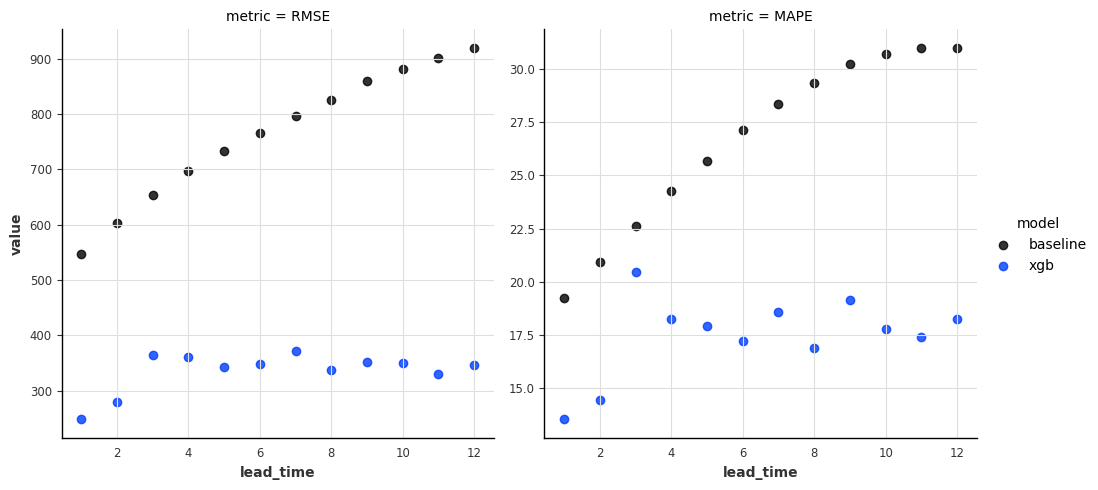

In [15]:
comparison = compare_model_with_baseline(
    test_target,
    selected_past_covariates_test,
    selected_future_covariates_test,
    xgbmodel,
    output_chunk_length,
)

sns.lmplot(
    data=comparison,
    x="lead_time",
    y="value",
    col="metric",
    hue="model",
    fit_reg=False,
    facet_kws=dict(sharey=False),
);